In [1]:
# set jupyter auto reload and 2
%load_ext autoreload
%autoreload 2
from omegaconf import OmegaConf
import torch
from torch.optim import lr_scheduler
import torch.nn as nn

from tqdm import tqdm
from utils.train_utils import select_device, fix_seed, log_images, calculate_metrics_fromloader, pred_fn, image_float2int
from utils.builder import build_data, build_models, build_optimizer
import torch.nn.functional as F
import wandb
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import os

wandb.login(key="d86336fbe1e8b0ef444fa1f7f67208a1333b7176")
print("logged in ")
wandb.finish()
assert wandb.run is None


/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: pstha (eye2gene). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/binod/.netrc


logged in 


In [2]:
wandb.init(project="Eye2Gene", entity="pstha", name="res_VAE_oct_no_feature")
print("init")

wandb: Currently logged in as: pstha. Use `wandb login --relogin` to force relogin


init


In [4]:
configs = OmegaConf.load('./config/mae/vae_kaggle_oct_small.yaml')
gpus = select_device('0', configs.data.batch_size)
fix_seed(2023)
train_loader, val_loader, test_loader = build_data(configs)

In [5]:
# create loaders for mnist
# from torchvision.datasets import MNIST
# from torchvision import transforms

# #upscale to 64 by 64 during transform
# train_dataset = MNIST("/mnt/Enterprise/prashant/mnist/", train = True, transform=transforms.Compose([
#     transforms.Resize(64),
#     transforms.ToTensor()
# ]))
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
# test_dataset = MNIST("/mnt/Enterprise/prashant/mnist/", train = False, transform=transforms.Compose([
#     transforms.Resize(64),
#     transforms.ToTensor()
# ]))
# test_batch_size = 64
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size)


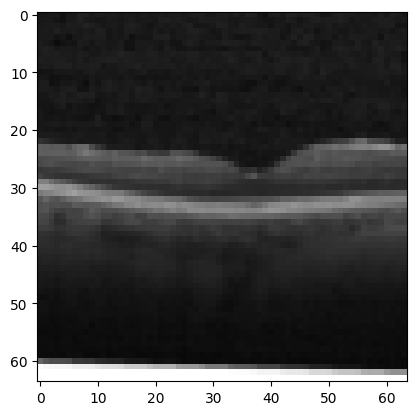

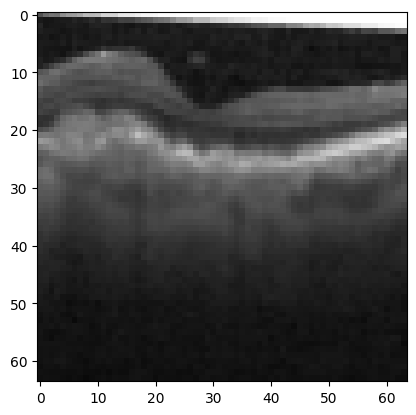

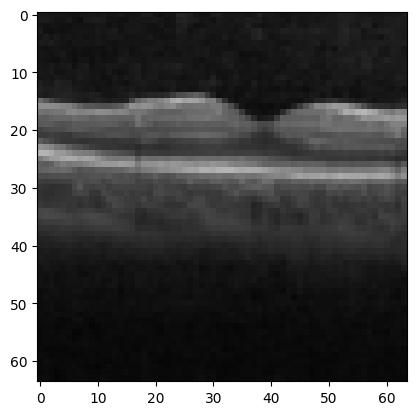

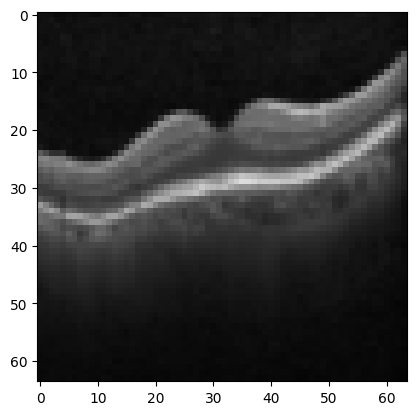

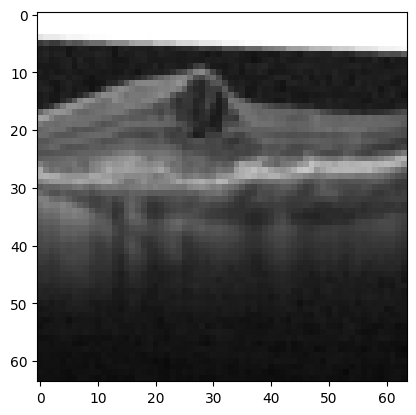

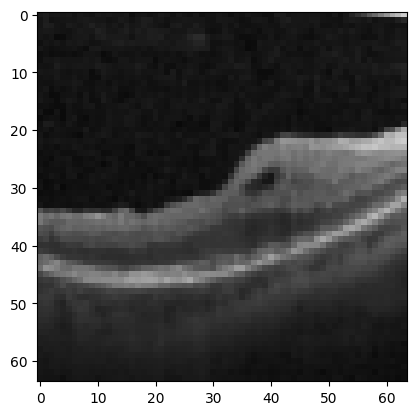

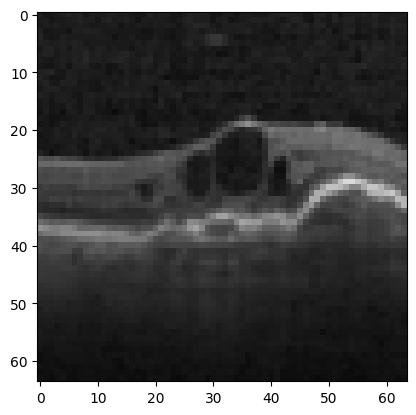

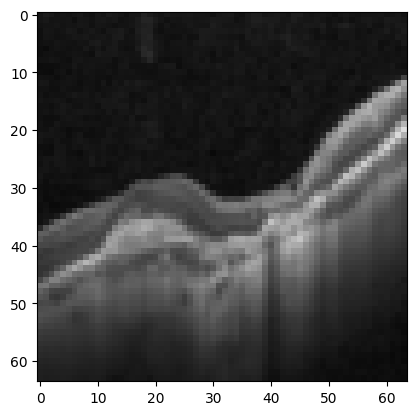

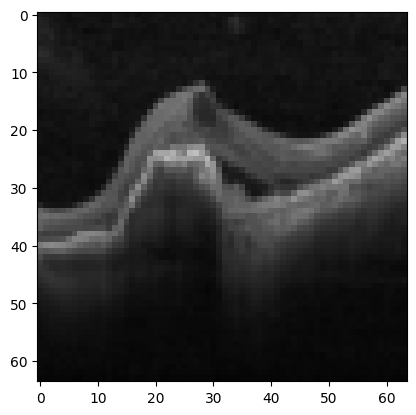

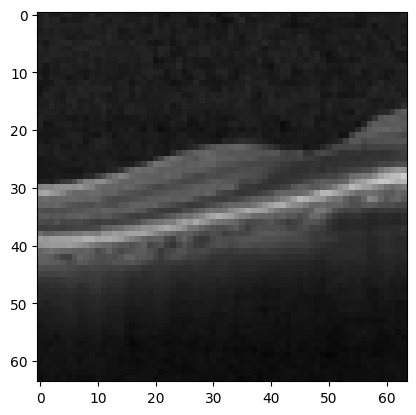

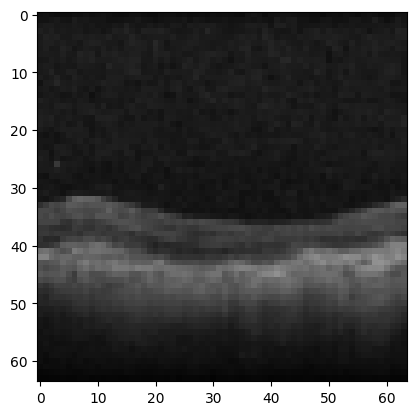

In [5]:
# print few images
for batch in train_loader:
    images = batch["image"]
    for i in range(images.size()[0]):
        plt.imshow(((((images[i]+1)*0.5).permute(1,2,0))).numpy())
        plt.show()
        if i == 10:
            break
    break
    

In [6]:
def kl_loss_fn(mu, logvar):
    return -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()

import torch.nn as nn
import torch


class VGG19(nn.Module):
    """
     Simplified version of the VGG19 "feature" block
     This module's only job is to return the "feature loss" for the inputs
    """

    def __init__(self, channel_in=3, width=64):
        super(VGG19, self).__init__()

        self.conv1 = nn.Conv2d(channel_in, width, 3, 1, 1)
        self.conv2 = nn.Conv2d(width, width, 3, 1, 1)

        self.conv3 = nn.Conv2d(width, 2 * width, 3, 1, 1)
        self.conv4 = nn.Conv2d(2 * width, 2 * width, 3, 1, 1)

        self.conv5 = nn.Conv2d(2 * width, 4 * width, 3, 1, 1)
        self.conv6 = nn.Conv2d(4 * width, 4 * width, 3, 1, 1)
        self.conv7 = nn.Conv2d(4 * width, 4 * width, 3, 1, 1)
        self.conv8 = nn.Conv2d(4 * width, 4 * width, 3, 1, 1)

        self.conv9 = nn.Conv2d(4 * width, 8 * width, 3, 1, 1)
        self.conv10 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv11 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv12 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)

        self.conv13 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv14 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv15 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)
        self.conv16 = nn.Conv2d(8 * width, 8 * width, 3, 1, 1)

        self.mp = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        self.load_params_()

    def load_params_(self):
        # Download and load Pytorch's pre-trained weights
        state_dict = torch.hub.load_state_dict_from_url('https://download.pytorch.org/models/vgg19-dcbb9e9d.pth')
        for ((name, source_param), target_param) in zip(state_dict.items(), self.parameters()):
            target_param.data = source_param.data
            target_param.requires_grad = False

    def feature_loss(self, x):
        return (x[:x.shape[0] // 2] - x[x.shape[0] // 2:]).pow(2).mean()

    def forward(self, x):
        """
        :param x: Expects x to be the target and source to concatenated on dimension 0
        :return: Feature loss
        """
        x = self.conv1(x)
        loss = self.feature_loss(x)
        x = self.conv2(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 64x64

        x = self.conv3(x)
        loss += self.feature_loss(x)
        x = self.conv4(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 32x32

        x = self.conv5(x)
        loss += self.feature_loss(x)
        x = self.conv6(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv7(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv8(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 16x16

        x = self.conv9(x)
        loss += self.feature_loss(x)
        x = self.conv10(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv11(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv12(self.relu(x))
        loss += self.feature_loss(x)
        x = self.mp(self.relu(x))  # 8x8

        x = self.conv13(x)
        loss += self.feature_loss(x)
        x = self.conv14(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv15(self.relu(x))
        loss += self.feature_loss(x)
        x = self.conv16(self.relu(x))
        loss += self.feature_loss(x)

        return loss/16


In [7]:
from models.res_vae import VAE
loss_log = []
nepoch = 100
start_epoch = 0

device = 'cuda:0'
vae_net = VAE(channel_in=3, ch=64).to(device)
# setup optimizer
lr = 1e-4
optimizer = torch.optim.Adam(vae_net.parameters(), lr=lr, betas=(0.5, 0.999))

In [6]:


# # load checkpoint
# ckpt = torch.load('/mnt/Enterprise/prashant/logs/VAE_latest.pth')
# vae_net.load_state_dict(ckpt['vae_net'])
# optimizer.load_state_dict(ckpt['optimizer'])
# start_epoch = ckpt['epoch']
# #best_loss = ckpt['best_loss']
# print('Loaded checkpoint from epoch %d.' % start_epoch)



Loaded checkpoint from epoch 35.


In [8]:

#Loss function

feature_extractor = VGG19().to(device)

In [9]:
def plot_tsne(model, data_loader, config, title='val set'): 
    model.eval()
    X = []
    X_labels = []
    for batch in tqdm(data_loader):
        features, _, _ = model.encoder(batch["image"].to(device))
        features = features.view(features.size(0), -1)
        labels = batch["label"].to(device)
        X.append(features.detach().cpu().numpy())
        X_labels.append(labels.detach().cpu().numpy())

    # get X and X labels
    X = np.concatenate(X, axis=0)
    X_labels = np.concatenate(X_labels, axis=0)
    print(X.shape, X_labels.shape)
    
    k = 4

    # Create a KMeans object
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    # Get the labels for each data point
    kmeans_labels = kmeans.labels_

    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(X)
    dftsne = pd.DataFrame(tsne_embeddings)
    dftsne['cluster'] = pd.Series(X_labels)
    dftsne.columns = ['x1','x2','cluster']
    
    dftsne_kmeans = dftsne.copy()
    dftsne_kmeans['cluster'] = kmeans_labels
    os.makedirs(f"output/{config.model_type}", exist_ok=True)
    
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",palette="deep", alpha=0.5).set_title(title + ", cluster colors using ground truth")
    plt.show()
    # plt.savefig(f"output/{config.model_type}/tsne_gt.png")
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=dftsne_kmeans,x='x1', y='x2', hue='cluster', legend='full', palette="deep", alpha=0.5).set_title(title+", cluster colors using k means")
    plt.show()
    # plt.savefig(f"output/{config.model_type}/tsne_kmeans.png")

    print(title, metrics.rand_score(dftsne['cluster'], dftsne_kmeans['cluster']))
    print(title, metrics.adjusted_rand_score(dftsne['cluster'], dftsne_kmeans['cluster']))

Train error for epoch 1: 1.188106239414032
Val error for epoch 1: 0.05140450424872912


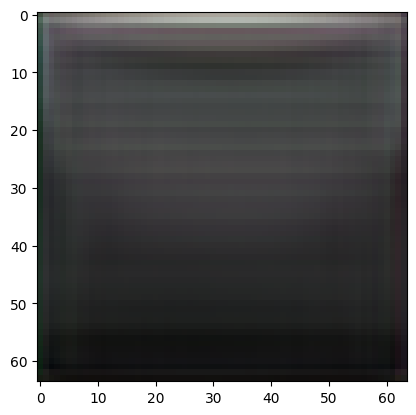

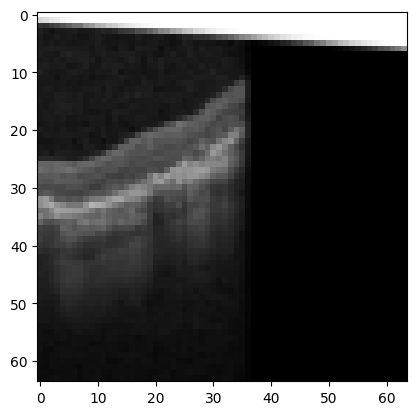

100%|██████████| 131/131 [00:08<00:00, 14.96it/s]
/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(16697, 512) (16697,)


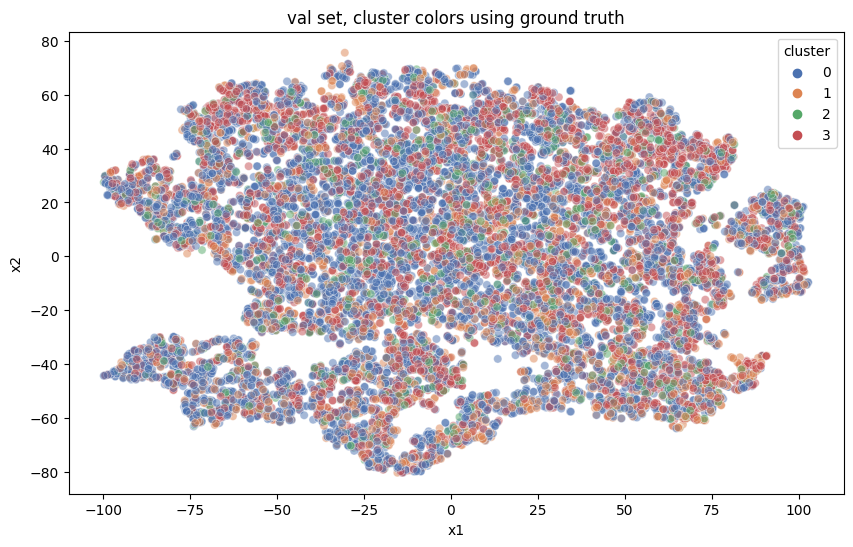

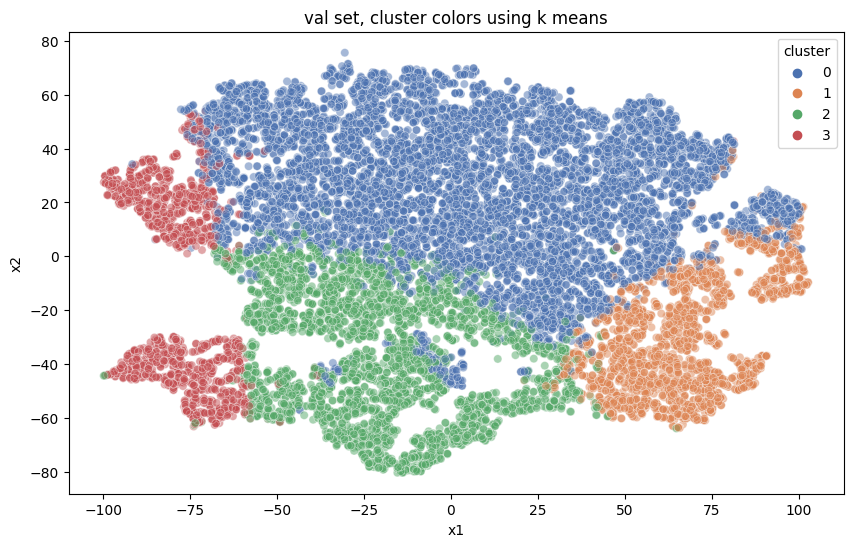

val set 0.5491977217659356
val set 0.008534808849472216
Train error for epoch 2: 2.3947778554658288
Val error for epoch 2: 0.05265370223384637
Train error for epoch 3: 0.8161072236791453
Val error for epoch 3: 0.04551331469645867
Train error for epoch 4: 0.8476159210511681
Val error for epoch 4: 0.04423244137030381
Train error for epoch 5: 0.5263667720407533
Val error for epoch 5: 0.04794814113814097
Train error for epoch 6: 0.7885999936403102
Val error for epoch 6: 0.037442397498167475


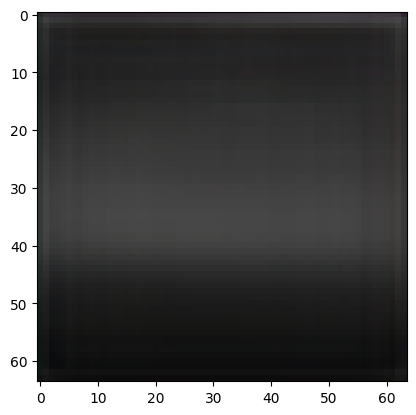

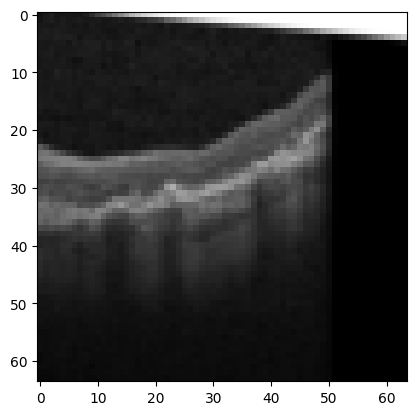

Train error for epoch 7: 0.4712808581208542
Val error for epoch 7: 0.0587268055918125
Train error for epoch 8: 0.4874224070738465
Val error for epoch 8: 0.044668469864588514
Train error for epoch 9: 0.4975514822065716
Val error for epoch 9: 0.038585959976682294
Train error for epoch 10: 195.48424715278475
Val error for epoch 10: 3.2299040528444145
Train error for epoch 11: 13.864247956340007
Val error for epoch 11: 0.7820073666480871


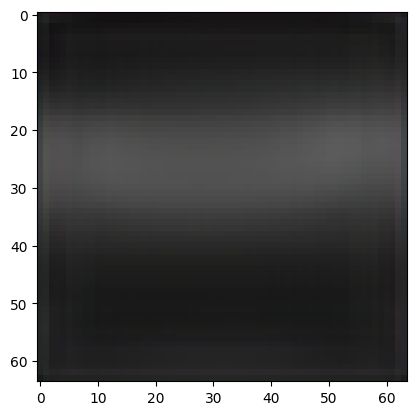

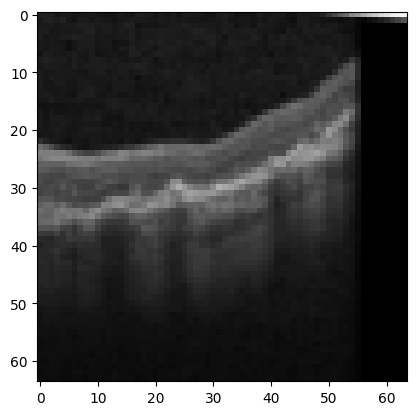

100%|██████████| 131/131 [00:08<00:00, 15.05it/s]
/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(16697, 512) (16697,)


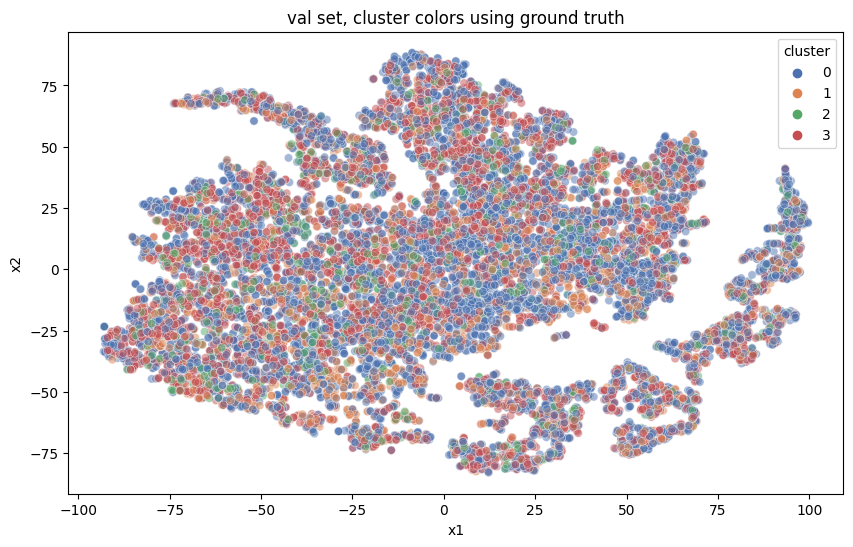

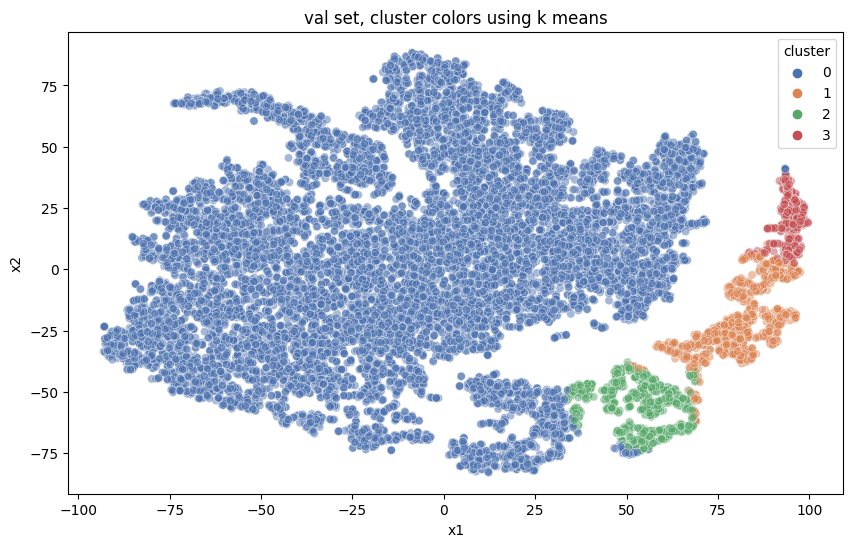

val set 0.4015623501021146
val set -0.006460199615167328
Train error for epoch 12: 5.105998022771385
Val error for epoch 12: 0.3680861548735545
Train error for epoch 13: 2.9283443121900943
Val error for epoch 13: 0.2531997690980251
Train error for epoch 14: 2.085307588504052
Val error for epoch 14: 0.1784712667648609
Train error for epoch 15: 1.563626526756616
Val error for epoch 15: 0.13701872567717846


In [17]:
use_perception=False
# error = 0
loss_log = []
best_val_error = 10e7
for epoch in range(start_epoch, nepoch):
    vae_net.train()
    error = 0
    for i, batch in enumerate(train_loader):
        
        images = batch['image']
        
        # images = batch[0]
        # print(images.shape)
        # exit()
        images = images.to(device)
        images = (images + 1)*0.5

        recon_img, mu, logvar = vae_net(images)
        #VAE loss
        kl_loss = kl_loss_fn(mu, logvar)
        mse_loss = F.mse_loss(recon_img, images)
        
        #Perception loss
        if use_perception:
            feat_in = torch.cat((recon_img, images), 0)
            feature_loss = feature_extractor(feat_in)
        else:
            feature_loss = 0.0
        
        loss = 10*kl_loss + 15*mse_loss + feature_loss
    
        loss_log.append(loss.item())
        vae_net.zero_grad()
        loss.backward()
        optimizer.step()

        error += torch.linalg.norm(loss).item()
        # i += 1
        wandb.log({"loss": loss.item(), "mse_loss": mse_loss.item(), "kl_loss": kl_loss.item(), "feature_loss": feature_loss})
    print(f"Train error for epoch {epoch + 1}: {error / i}")
    

    # eval
    vae_net.eval()
    with torch.no_grad():
        val_error = 0
        for j, batch in enumerate(val_loader):
            images = batch["image"]
            images = images.to(device)
            images = (images + 1)*0.5
            recon_img, mu, logvar = vae_net(images)
            kl_loss = kl_loss_fn(mu, logvar)
            mse_loss = F.mse_loss(recon_img, images)

            if use_perception:
                feat_in = torch.cat((recon_img, images), 0)
                feature_loss = feature_extractor(feat_in)
            else:
                feature_loss = 0.0
            
            loss = kl_loss + mse_loss + feature_loss
            val_error += torch.linalg.norm(loss).item()
            wandb.log({"val_loss": loss.item(), "val_mse_loss": mse_loss.item(), "val_kl_loss": kl_loss.item(), "val_feature_loss": feature_loss})
        print(f"Val error for epoch {epoch + 1}: {val_error / j}")

        epoch_error = val_error / j
        if epoch_error < best_val_error:
            best_val_error = epoch_error
            ckpt = {
                "epoch": epoch,
                "vae_net": vae_net.state_dict(),
                "optimizer": optimizer.state_dict(),
                "best_loss": best_val_error
            }
            torch.save(ckpt, f"/mnt/Enterprise/prashant/logs/VAE_best.pth")
        
        if epoch % 5 == 0:
            ckpt = {
                "epoch": epoch,
                "vae_net": vae_net.state_dict(),
                "optimizer": optimizer.state_dict(),
                "best_loss": best_val_error
            }
            torch.save(ckpt, f"/mnt/Enterprise/prashant/logs/VAE_latest.pth")
        
            for batch in val_loader:
                images = batch["image"]
                images = images.to(device)
                images = (images + 1)*0.5
                recon_img, mu, logvar = vae_net(images)
                # display recon_img
                plt.imshow(((recon_img[0].permute(1,2,0))).detach().cpu().numpy())
                plt.show()
                plt.imshow(((images[0].permute(1,2,0))).detach().cpu().numpy())
                plt.show()
                break

                
        if epoch % 10 == 0:
            plot_tsne(vae_net, val_loader, configs, title='val set')


In [10]:
# def plot_tsne(model, data_loader, config, title='val set'): 
#     model.eval()
#     X = []
#     X_labels = []
#     for batch in tqdm(data_loader):
#         features, _, _ = model.encoder(batch[0].to(device))
#         features = features.view(features.size(0), -1)
#         labels = batch[1].to(device)
#         X.append(features.detach().cpu().numpy())
#         X_labels.append(labels.detach().cpu().numpy())

#     # get X and X labels
#     X = np.concatenate(X, axis=0)
#     X_labels = np.concatenate(X_labels, axis=0)
#     print(X.shape, X_labels.shape)
    
#     k = 10

#     # Create a KMeans object
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(X)
#     # Get the labels for each data point
#     kmeans_labels = kmeans.labels_

#     tsne = TSNE(n_components=2, random_state=42)
#     tsne_embeddings = tsne.fit_transform(X)
#     dftsne = pd.DataFrame(tsne_embeddings)
#     dftsne['cluster'] = pd.Series(X_labels)
#     dftsne.columns = ['x1','x2','cluster']
    
#     dftsne_kmeans = dftsne.copy()
#     dftsne_kmeans['cluster'] = kmeans_labels
#     os.makedirs(f"output/{config.model_type}", exist_ok=True)
    
#     plt.figure(figsize=(10,6))
#     sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",palette="deep", alpha=0.5).set_title(title + ", cluster colors using ground truth")
#     plt.show()
#     # plt.savefig(f"output/{config.model_type}/tsne_gt.png")
#     plt.figure(figsize=(10,6))
#     sns.scatterplot(data=dftsne_kmeans,x='x1', y='x2', hue='cluster', legend='full', palette="deep", alpha=0.5).set_title(title+", cluster colors using k means")
#     plt.show()
#     # plt.savefig(f"output/{config.model_type}/tsne_kmeans.png")

#     print(title, metrics.rand_score(dftsne['cluster'], dftsne_kmeans['cluster']))
#     print(title, metrics.adjusted_rand_score(dftsne['cluster'], dftsne_kmeans['cluster']))

100%|██████████| 157/157 [00:05<00:00, 27.24it/s]
/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(10000, 512) (10000,)


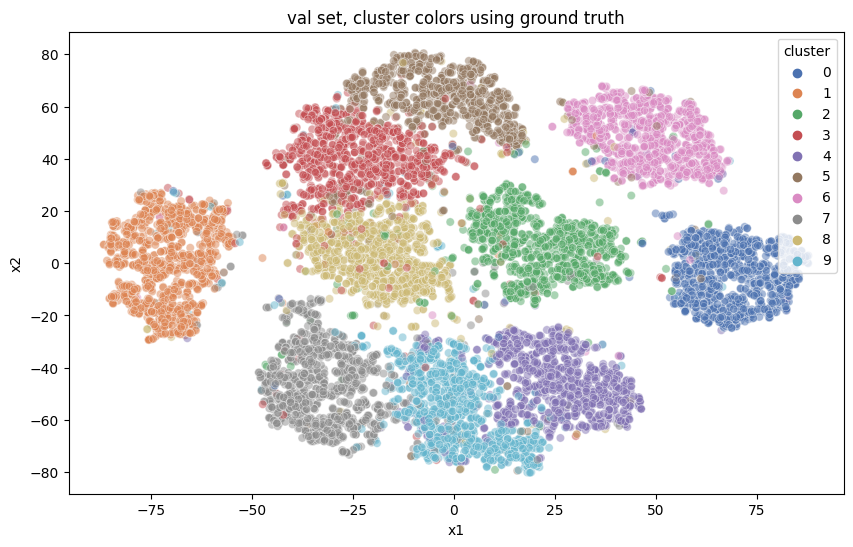

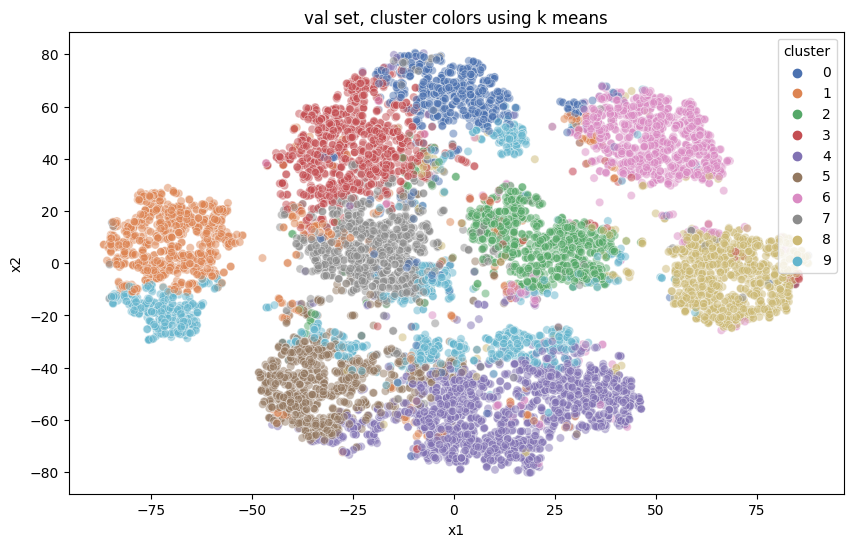

val set 0.9116764676467647
val set 0.520950264991531


In [11]:
# plot_tsne(vae_net, test_loader, configs, title='val set')

  0%|          | 0/131 [00:00<?, ?it/s]100%|██████████| 131/131 [00:19<00:00,  6.71it/s]
/home/binod/.anaconda3/envs/eye2gene/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(16697, 512) (16697,)


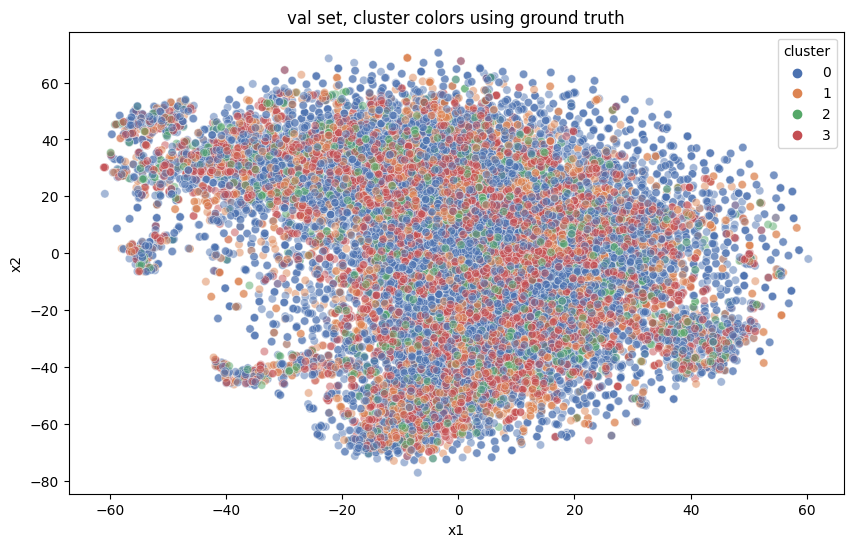

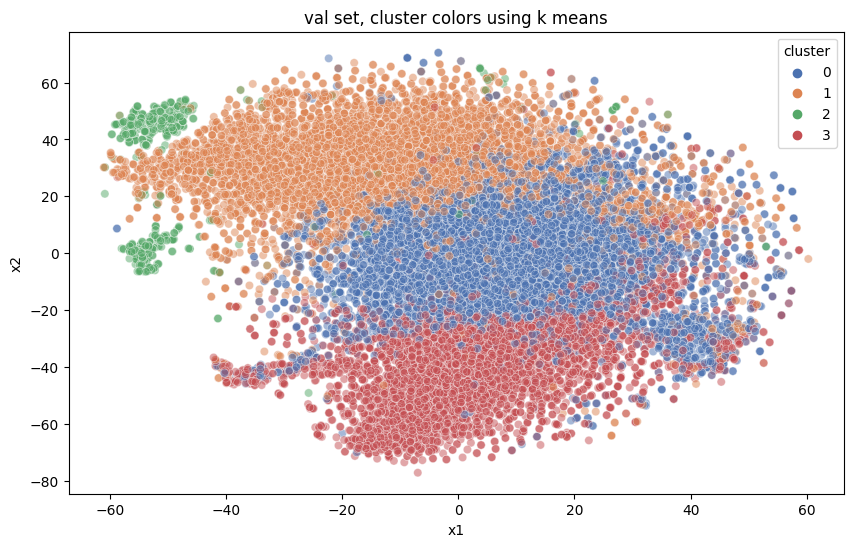

val set 0.5637158435853742
val set 0.004081442788551574


In [17]:
plot_tsne(vae_net, val_loader, configs, title='val set')